In [1]:
%%bash
pip install pandas scikit-learn matplotlib multiprocess jupyterlab accelerate transformers
nvidia-smi
unzip /content/data.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.


# 1. MNIST


## classification with SVM


In [45]:
import numpy as np
import sys
import os
from array import array

import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

from struct import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [46]:
train_lbl = [ [],[],[],[],[],[],[],[],[],[] ] #숫자별로 저장 (0 ~ 9)
test_lbl = [ [],[],[],[],[],[],[],[],[],[] ] #숫자별로 저장 (0 ~ 9)

In [47]:
def read_dataset(path_image, path_label, data_type): #파일 읽기
    mnist_image_origin = open(path_image,'rb')
    mnist_label_origin = open(path_label,'rb')

    #사용할 변수 초기화
    mnist_img = np.zeros((28,28)) #이미지가 저장될 부분

    label = 0
    index=0
    count_row = 0

    first_image_byte = mnist_image_origin.read(16)    #read first 16byte
    first_label_byte = mnist_label_origin.read(8)     #read first  8byte

    test_img = None

    while True:
        image = mnist_image_origin.read(784) #784바이트(= 28*28) 씩 읽음
        label = mnist_label_origin.read(1)   #1바이트씩 읽음

        if not image:
            break;
        if not label:
            break;

        index = int(label[0])

        #unpack
        mnist_img = np.reshape( unpack(len(image)*'B',image), (28,28))

        if data_type == 'train':
            train_lbl[index].append(mnist_img) #각 숫자영역별로 해당이미지를 추가
        else:
            test_lbl[index].append(mnist_img) #각 숫자영역별로 해당이미지를 추가
        count_row = count_row + 1

    print("read done " + str(count_row))

    return train_lbl if data_type == 'train' else test_lbl

In [48]:
def get_row(label, index_num, data_type):

    change_count = 0
    pre_val = 0
    feature = []
    featured_image = pd.DataFrame(columns = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15",
                                             "x16","x17","x18","x19","x20","x21","x22","x23","x24","x25","x26","x27","label"])

    check_img = None

    if data_type == 'train':
            check_img = train_lbl[int(label)][int(index_num)]
    else:
        check_img = test_lbl[int(label)][int(index_num)]


    for r in range(0,27):
        change_count = 0
        pre_val = 0

        for c in range(1,27):
            if check_img[r][c] == 0 and check_img[r][pre_val] > 0:
                change_count = change_count + 1
            elif check_img[r][c] > 0 and check_img[r][pre_val] == 0:
                change_count = change_count + 1

            pre_val = pre_val + 1

        feature.append(change_count)

    feature.append(label)
    featured_image.loc[0] = pd.Series(feature,index=featured_image.columns)

    return featured_image

In [49]:
train_mnist = read_dataset('mnist/train-images.idx3-ubyte','mnist/train-labels.idx1-ubyte', 'train')
test_mnist = read_dataset('mnist/t10k-images.idx3-ubyte','mnist/t10k-labels.idx1-ubyte', 'test')

read done 60000
read done 10000


In [50]:
def prep_work(number, return_df):

    # 전체 mnist 전처리
    mnist_train_data = pd.DataFrame(columns = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15",
                                               "x16","x17","x18","x19","x20","x21","x22","x23","x24","x25","x26","x27","label"])

    for n in range(0,len(train_mnist[number])):
        mnist_train_data = pd.concat([mnist_train_data, get_row(i,n,'train')], ignore_index=True)

    return_df[number] = mnist_train_data

In [51]:
import multiprocessing
manager = multiprocessing.Manager()
return_df = manager.dict()

procs = []
for i in range(10):
    p = multiprocessing.Process(target=prep_work, args=(i, return_df))
    p.start()
    procs.append(p)

for p in procs:
    p.join()  # 프로세스가 모두 종료될 때까지 대기

In [52]:
mnist_train_data = pd.DataFrame(columns = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15",
                                           "x16","x17","x18","x19","x20","x21","x22","x23","x24","x25","x26","x27","label"])

for i in range(10):
    mnist_train_data = mnist_train_data = pd.concat([mnist_train_data, return_df[i]], ignore_index=True)

mnist_train_data.shape

(60000, 28)

In [53]:
# 전체 mnist 전처리
mnist_test_data = pd.DataFrame(columns = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15",
                                           "x16","x17","x18","x19","x20","x21","x22","x23","x24","x25","x26","x27","label"])

for i in range(0,10):
    for n in range(0,len(test_mnist[i])):
        mnist_test_data = pd.concat([mnist_test_data, get_row(i,n,'test')], ignore_index=True)

mnist_test_data.shape

(10000, 28)

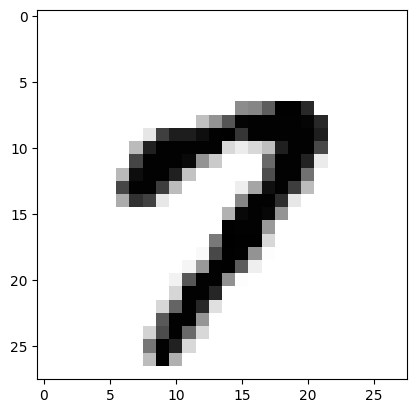

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 19

In [54]:
plt.imshow(train_lbl[7][0], cmap = cm.binary) #binary형태의 이미지 설정
plt.show()
print(test_lbl[7][0])

In [55]:
X = mnist_train_data[mnist_train_data.columns[:-1]]
y = mnist_train_data['label']
y = y.astype('int')

# SVM 모델 생성
model = SVC(kernel='poly', C = 3, degree = 3)
model.fit(X, y)

SVC(C=3, kernel='poly')

In [56]:
test_X = mnist_test_data[mnist_test_data.columns[:-1]]
test_y = mnist_test_data['label']
test_y = test_y.astype('int')

y_pred = model.predict(test_X)

f1_result = f1_score(test_y, y_pred, average = None)

print(f1_result)
print(np.mean(f1_result))

[0.9488978  0.89083333 0.68790497 0.53346266 0.85885287 0.6
 0.85087282 0.78718535 0.76091476 0.75092544]
0.766984999180955


In [57]:
confusion_matrix(test_y, y_pred)

array([[ 947,    0,    0,    1,   10,    2,   15,    1,    2,    2],
       [   3, 1069,    6,   20,    3,    8,   17,    5,    3,    1],
       [  10,   22,  637,  164,   18,   30,   93,    5,   52,    1],
       [   2,   75,   53,  550,    7,  168,   30,   42,   72,   11],
       [   7,    8,    8,   11,  861,    2,    7,   17,   28,   33],
       [   8,   56,   28,  188,    4,  504,   29,   42,   29,    4],
       [  23,    3,   40,   18,    3,   14,  853,    0,    4,    0],
       [   3,   21,    0,   25,    3,   15,    0,  860,    7,   94],
       [   8,   10,   44,   60,   46,   38,    3,    7,  732,   26],
       [   5,    1,    4,   15,   68,    7,    0,  178,   21,  710]])

## classification with CNN


In [58]:
import os
import os.path
import time
import gzip
import pickle

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [59]:
def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

In [60]:
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

In [61]:
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = "mnist"
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

dataset = {}
dataset['train_img'] =  _load_img(key_file['train_img'])
dataset['train_label'] = _load_label(key_file['train_label'])
dataset['test_img'] = _load_img(key_file['test_img'])
dataset['test_label'] = _load_label(key_file['test_label'])

with open(save_file, 'wb') as f:
    pickle.dump(dataset, f, -1)

for key in ('train_img', 'test_img'):
    dataset[key] = dataset[key].astype(np.float32)
    dataset[key] /= 255.0

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done


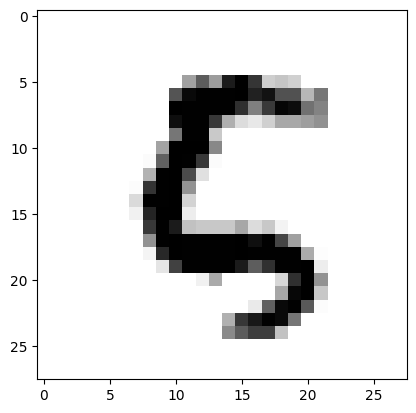

In [62]:
plt.imshow(dataset['train_img'][2000].reshape(28, 28), cmap = cm.binary) #binary형태의 이미지 설정
plt.show()

In [63]:
x_train, y_train, x_test, y_test = map(
    torch.tensor, (dataset['train_img'], dataset['train_label'], dataset['test_img'], dataset['test_label'])
)

print(x_train.shape)
print(y_train.min(), y_train.max())

torch.Size([60000, 784])
tensor(0, dtype=torch.uint8) tensor(9, dtype=torch.uint8)


In [64]:
batch_size = 100
n_epochs = 20

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_test, y_test)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

In [65]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1
loss_func = F.cross_entropy

In [66]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [67]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [68]:
torch.cuda.is_available()

True

In [69]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb.to(dev)), yb.to(dev))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [70]:
gpu_model = Mnist_CNN()
gpu_model.to(dev)
opt = optim.SGD(gpu_model.parameters(), lr=lr, momentum=0.9)

batch_size = 50

gpu_start = time.time()

fit(30, gpu_model, loss_func, opt, train_dl, valid_dl)

gpu_training_time = time.time() - gpu_start
print("gpu training time : ", round(gpu_training_time, 2))

0 0.4120639532804489
1 0.29701858513057233
2 0.22129604585468768
3 0.18734013862907886
4 0.21206289608031512
5 0.17921144492924213
6 0.16080014357343317
7 0.1404500347748399
8 0.1410425032582134
9 0.16952790711075066
10 0.17080741931684315
11 0.13891052099876106
12 0.13187062744051217
13 0.14832134518772364
14 0.13433033381123097
15 0.12009058293886482
16 0.1303255187626928
17 0.13285809851251543
18 0.12877988142892718
19 0.13855374116450547
20 0.11715421171858907
21 0.11613182965666055
22 0.12787758402526378
23 0.11897758316248655
24 0.1170037096273154
25 0.1056420622114092
26 0.10377934835851192
27 0.11225323620252312
28 0.1153785082581453
29 0.11321565054357052
gpu training time :  51.18


In [71]:
from sklearn.metrics import confusion_matrix, f1_score

predict_dev = torch.device("cpu")
gpu_model.to(predict_dev)

y_pred = gpu_model(x_test)

In [72]:
predict_result = []
label = dataset['test_label']
for r in range(0,10000):
    predict_result.append(np.argmax(y_pred.detach().numpy()[r]))

f1_result = f1_score(label, predict_result, average = None)
print(f1_result)
print(np.mean(f1_result))

[0.97212367 0.98586572 0.95789474 0.96461464 0.97012658 0.96158192
 0.96695096 0.96999508 0.95068632 0.95625943]
0.965609906466895


In [73]:
confusion_matrix(label, predict_result)

array([[ 959,    0,    5,    0,    4,    2,    1,    1,    7,    1],
       [   0, 1116,    2,    4,    5,    1,    1,    0,    6,    0],
       [   3,    1, 1001,    8,    1,    1,    0,    7,    6,    4],
       [   0,    0,    5,  995,    0,    1,    0,    2,    6,    1],
       [   2,    0,    4,    0,  958,    1,    2,    1,    4,   10],
       [   5,    0,    4,   19,    0,  851,    4,    2,    4,    3],
       [  10,    5,    8,    1,   11,    8,  907,    0,    7,    1],
       [   2,    2,   17,    7,    1,    4,    0,  986,    5,    4],
       [   8,    1,    7,    8,    2,    5,    2,    1,  935,    5],
       [   4,    4,    5,   11,   11,    4,    1,    5,   13,  951]])

# 2. LlaVa


In [33]:
import os, time
from google.colab import userdata
from IPython.display import Markdown
os.environ["HF_TOKEN"] = userdata.get('HF_WRITE_TOKEN')

In [34]:
import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/5.07k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

In [40]:
def generate_response(user_prompt, image):
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": user_prompt}
        ]}
    ]
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to(model.device)
    output = model.generate(**inputs, max_new_tokens=300)

    return processor.decode(output[0])

In [41]:
image_path = "/content/image/영수증.png"

image = Image.open(image_path)
image.show()

In [44]:
user_prompt = "사진의 영수증으로 언제 비용지불 한것인지와 어떤 물품을 구매한것인지 정리해줘."
image_path = "/content/image/영수증_1.png"
image = Image.open(image_path)

start_time = time.time()
response_llm = generate_response(user_prompt, image)
end_time = time.time()

display(Markdown(response_llm))
execution_time = end_time - start_time
print(f"실행 시간: {execution_time:.4f} 초")

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>사진의 영수증으로 언제 비용지불 한것인지와 어떤 물품을 구매한것인지 정리해줘.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

사진의 영수증을 분석해 보았습니다.

*   **영수증의 날짜**: 영수증의 날짜는 12월 12일 2020년입니다.
*   **영수증의 총 비용**: 영수증의 총 비용은 51.00 달러입니다.
*   **영수증의 결제 방법**: 영수증의 결제 방법은 카드 결제입니다.
*   **영수증의 주문 내역**:

    *   치킨 캐리 1개 (11.00 달러)
    *   후라이드 치킨 2개 (10.00 달러)
    *   치즈 버거 2개 (8.00 달러)
    *   맥주 2개 (8.00 달러)
    *   물 2개 (2.00 달러)
    *   케첩 1개 (1.00 달러)
    *   소스 1개 (1.00 달러)
    *   기타 2개 (10.00 달러)

영수증을 분석해 보았습니다. 영수증의 날짜는 12월 12일 2020년이고, 총 비용은 51.00 달러입니다. 결제 방법은 카드 결제입니다. 주문 내역은 다음과 같습니다.

*   치킨 캐리 1개 (11.00

실행 시간: 138.3703 초
